In [41]:
from database.strategy import Strategy
from database.sec import SEC
from database.market import Market
from transformer.date_transformer import DateTransformer
from transformer.column_transformer import ColumnTransformer
from transformer.model_transformer import ModelTransformer
from transformer.product_transformer import ProductTransformer
from transformer.predictor_transformer import PredictorTransformer
from preprocessor.model_preprocessor import ModelPreprocessor
from preprocessor.predictor_preprocessor import PredictorPreprocessor
from modeler.modeler import Modeler as sp
from utils.date_utils import DateUtils
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
import math

In [58]:
## Loading Constants
start = "2008-01-01"
end = datetime(2021,1,1).strftime("%Y-%m-%d")
# Loading Databases
strat_db = Strategy("unity")
market = Market()
sec = SEC("sec")
market.connect()
tickers = market.retrieve_data("sp500").sort_values("Symbol")
market.close()
quarterly_range = range(1,5)
yearly_range = range(2018,2021)
model_range = range(len(tickers["Symbol"]))

In [43]:
market.connect()
quarterly_classification_data = market.retrieve_data("dataset_pdr_quarter_classification")
quarterly_regression_data = market.retrieve_data("dataset_pdr_quarter_regression")
accurate = market.retrieve_data("accurate")
relevant_tickers = list(accurate["ticker"])
relevant_tickers.extend(["date","year","quarter"])
market.close()
for col in quarterly_regression_data.columns:
    if -99999 == quarterly_regression_data[col].min() or col not in relevant_tickers:
        quarterly_regression_data.drop(col,axis=1,inplace=True)
for col in quarterly_classification_data.columns:
    if -99999 == quarterly_classification_data[col].min() or col not in relevant_tickers:
        quarterly_classification_data.drop(col,axis=1,inplace=True)

In [59]:
sims = []
yearly_gap = 1
training_years = 7
sec.connect()
strat_db.connect()
market.connect()
strat_db.drop_table("quarterly_fundamental_sim")
for year in tqdm(yearly_range):
    for quarter in tqdm(quarterly_range):
        try:
            ### switch to all tickers
            for ticker in list(accurate["ticker"]):
                try:
                    cik = int(tickers[tickers["Symbol"]==ticker]["CIK"].item())
                    filing = sec.retrieve_filing_data(cik)
                    funds = filing.copy()
                    ## date transformations and gap management
                    funds["filed"] = [datetime.strptime(str(x),"%Y%m%d").replace(tzinfo=timezone.utc) if "-" not in str(x) else \
                                        datetime.strptime(str(x).split(" ")[0],"%Y-%m-%d").replace(tzinfo=timezone.utc) for x in funds["filed"]]
                    funds["quarter"] = [x.quarter for x in funds["filed"]]
                    funds["year"] = [x.year for x in funds["filed"]]
                    funds.drop(["_id","adsh","cik","filed"],axis=1,inplace=True)
                    funds.fillna(0,inplace=True)
                    for column in funds:
                        missing_rate = len(funds[funds[column] ==0]) / len(funds)
                        if missing_rate > 0.1:
                            funds.drop(column,axis=1,inplace=True)
                    ## merge
                    price = quarterly_regression_data[["year","quarter",ticker]].copy()
                    price["year"]  = price["year"] - yearly_gap
                    ticker_data = funds.merge(price,on=["year","quarter"])
                    ticker_data.rename(columns={ticker:"adjclose"},inplace=True)
                    ## regression_model
                    first = ticker_data[(ticker_data["year"] == year - training_years) & (ticker_data["quarter"] == quarter)].index.values.tolist()[0]
                    last = ticker_data[(ticker_data["year"] == year) & (ticker_data["quarter"] == quarter)].index.values.tolist()[0]
                    rfd = ticker_data.iloc[first:last-1]
                    mr = ModelPreprocessor(ticker)
                    refined = mr.fundamental_preprocess(rfd.copy())
                    factors = refined["X"].columns
                    rfr = sp.regression(refined,ranked=False,tf=False,deep=False)
                    price = quarterly_classification_data[["year","quarter",ticker]].copy()
                    price["year"]  = price["year"] - yearly_gap
                    ticker_data = funds.merge(price,on=["year","quarter"])
                    ticker_data.rename(columns={ticker:"adjclose"},inplace=True)
                    ## regression_model
                    first = ticker_data[(ticker_data["year"] == year - training_years) & (ticker_data["quarter"] == quarter)].index.values.tolist()[0]
                    last = ticker_data[(ticker_data["year"] == year) & (ticker_data["quarter"] == quarter)].index.values.tolist()[0]
                    cfd = ticker_data.iloc[first:last-1]
                    refined = mr.fundamental_preprocess(cfd.copy())
                    cfr = sp.classification(refined,tf=False,deep=False)
                    fundamental_results = pd.DataFrame([cfr,rfr])
                    ## merge
                    price = {"ticker":ticker,"year":year+yearly_gap,"quarter":quarter}
                    for i in range(len(fundamental_results)):
                        fundamental_result = fundamental_results.iloc[i]
                        final = funds[(funds["year"] == year) & (funds["quarter"] == quarter)]
                        product_refined = final[factors].copy()
                        prediction = fundamental_result["model"].predict(product_refined)[0]
                        if fundamental_result["api"] == "tf":
                            p = []
                            [p.extend(x) for x in prediction]
                            prediction = p
                        column_name = "quarterly_fundamental_{}".format(fundamental_result["model_type"])
                        price["{}_prediction".format(column_name)] = prediction
                        price["{}_score".format(column_name)] = fundamental_result["score"]
                    strat_db.store_data("quarterly_fundamental_sim".format(column_name),pd.DataFrame([price]))
                except Exception as e:
                    message = {"status":"quarterly modeling","ticker":ticker,"year":str(year),"quarter":str(quarter),"message":str(e)}
                    print(message)
                    strat_db.store_data("fundamental_quarterly_sim_errors",pd.DataFrame([message]))
        except Exception as e:
            print(year,quarter,str(e))
sec.close()
market.close()
strat_db.close()

  0%|                                                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2018', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2018', 'quarter': '1', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2018', 'quarter': '1', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'BIO', 'year': '2018', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2018', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'TYL', 'year': '2018', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2018', 'quarter': '1', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2018', 'quarter': '1', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modelin


 25%|█████████████████████████████████████████████▌                                                                                                                                        | 1/4 [01:01<03:05, 61.67s/it]

{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2018', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2018', 'quarter': '2', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2018', 'quarter': '2', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2018', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'TYL', 'year': '2018', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2018', 'quarter': '2', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2018', 'quarter': '2', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'INFO', 'year': '2018', 'quarter': '2', 'message': '"[\'INFO\'] not in index"'}



 50%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2/4 [02:18<02:12, 66.12s/it]

{'status': 'quarterly modeling', 'ticker': 'AZO', 'year': '2018', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2018', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'CPRT', 'year': '2018', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2018', 'quarter': '3', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2018', 'quarter': '3', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2018', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2018', 'quarter': '3', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2018', 'quarter': '3', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeli


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3/4 [03:30<01:07, 67.99s/it]

{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2018', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2018', 'quarter': '4', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2018', 'quarter': '4', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2018', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2018', 'quarter': '4', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2018', 'quarter': '4', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'INFO', 'year': '2018', 'quarter': '4', 'message': '"[\'INFO\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'ADBE', 'year': '2018', 'quarter': '4', 'message': 'list index out of range'}



  0%|                                                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2019', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2019', 'quarter': '1', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2019', 'quarter': '1', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'BIO', 'year': '2019', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2019', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2019', 'quarter': '1', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2019', 'quarter': '1', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'INFO', 'year': '2019', 'quarter': '1', 'message': '"[\'INFO\'] not in index"'}



 25%|█████████████████████████████████████████████▌                                                                                                                                        | 1/4 [01:14<03:43, 74.61s/it]

{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2019', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2019', 'quarter': '2', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2019', 'quarter': '2', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2019', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2019', 'quarter': '2', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2019', 'quarter': '2', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'INFO', 'year': '2019', 'quarter': '2', 'message': '"[\'INFO\'] not in index"'}



 50%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2/4 [02:31<02:30, 75.24s/it]

{'status': 'quarterly modeling', 'ticker': 'AZO', 'year': '2019', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2019', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'CPRT', 'year': '2019', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2019', 'quarter': '3', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2019', 'quarter': '3', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2019', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2019', 'quarter': '3', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2019', 'quarter': '3', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeli


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3/4 [03:47<01:15, 75.46s/it]

{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2019', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2019', 'quarter': '4', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2019', 'quarter': '4', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2019', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2019', 'quarter': '4', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2019', 'quarter': '4', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'INFO', 'year': '2019', 'quarter': '4', 'message': '"[\'INFO\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'ADBE', 'year': '2019', 'quarter': '4', 'message': 'list index out of range'}



  0%|                                                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2020', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'IQV', 'year': '2020', 'quarter': '1', 'message': '"[\'IQV\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'CHTR', 'year': '2020', 'quarter': '1', 'message': '"[\'CHTR\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'GOOGL', 'year': '2020', 'quarter': '1', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FLT', 'year': '2020', 'quarter': '1', 'message': '"[\'FLT\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'KEYS', 'year': '2020', 'quarter': '1', 'message': '"[\'KEYS\'] not in index"'}
{'status': 'quarterly modeling', 'ticker': 'INFO', 'year': '2020', 'quarter': '1', 'message': '"[\'INFO\'] not in index"'}



 25%|█████████████████████████████████████████████▌                                                                                                                                        | 1/4 [01:17<03:51, 77.01s/it]

{'status': 'quarterly modeling', 'ticker': 'BRK-B', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'LH', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'AZO', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'HSIC', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'SNPS', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FISV', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'CPRT', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', '


 50%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2/4 [01:47<02:06, 63.17s/it]

{'status': 'quarterly modeling', 'ticker': 'BSX', 'year': '2020', 'quarter': '2', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'BRK-B', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'LH', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'AZO', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'HSIC', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'SNPS', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FISV', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 't


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3/4 [02:19<00:53, 53.75s/it]

{'status': 'quarterly modeling', 'ticker': 'BSX', 'year': '2020', 'quarter': '3', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'BRK-B', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'LH', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'AZO', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'HSIC', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'SNPS', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'FISV', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 'ticker': 'GOOG', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}
{'status': 'quarterly modeling', 't


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [12:38<00:00, 252.87s/it]

{'status': 'quarterly modeling', 'ticker': 'BSX', 'year': '2020', 'quarter': '4', 'message': 'list index out of range'}


In [53]:
price

{'ticker': 'BRK-B',
 'year': 2019,
 'quarter': 1,
 'quarterly_fundamental_classification_prediction': 1.0,
 'quarterly_fundamental_classification_score': 0.8571428571428571,
 'quarterly_fundamental_regression_prediction': 86.73561,
 'quarterly_fundamental_regression_score': 0.9661513427627195}

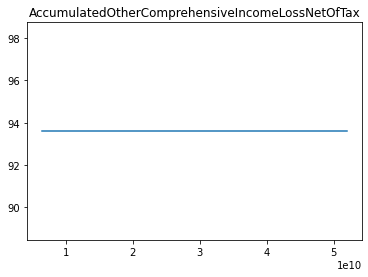

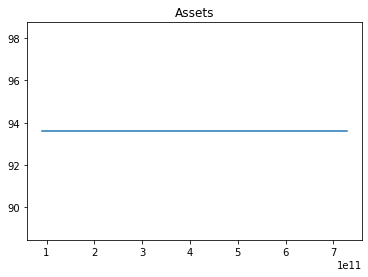

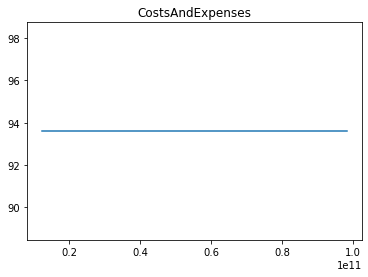

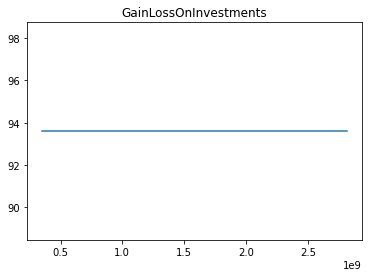

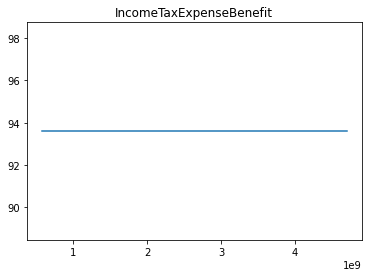

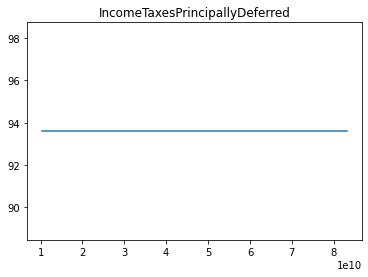

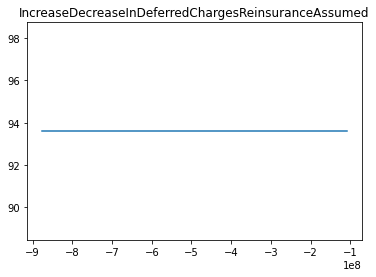

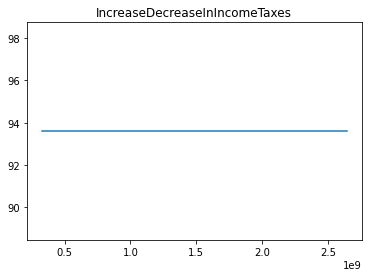

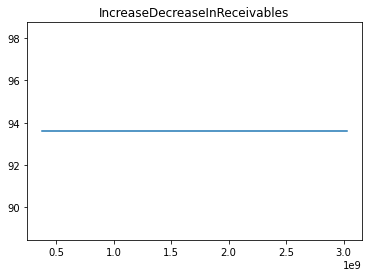

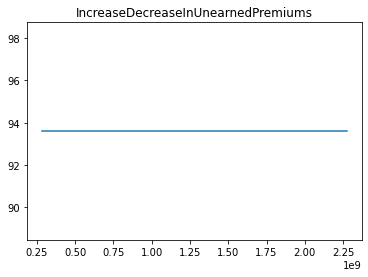

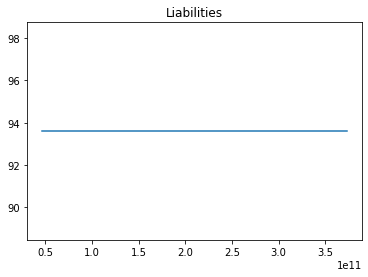

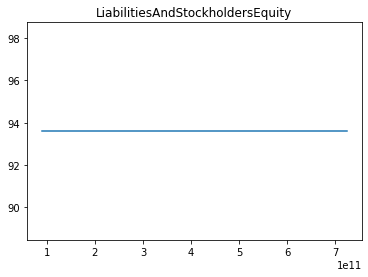

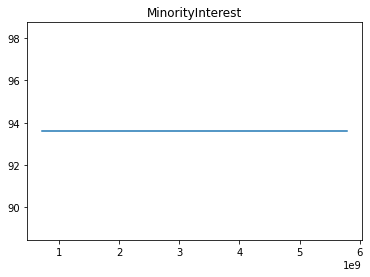

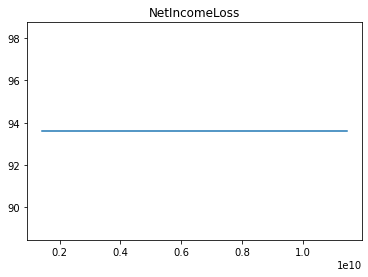

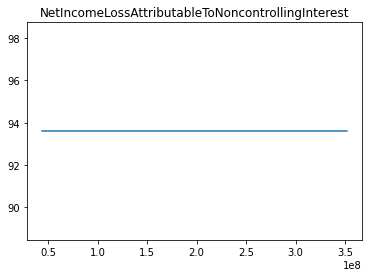

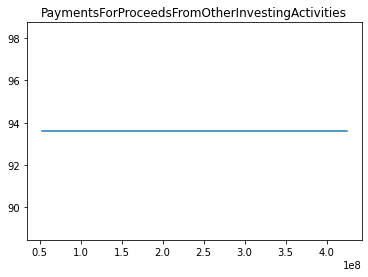

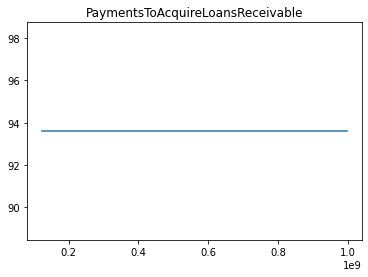

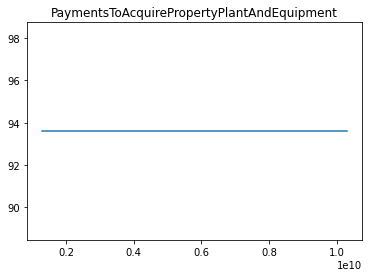

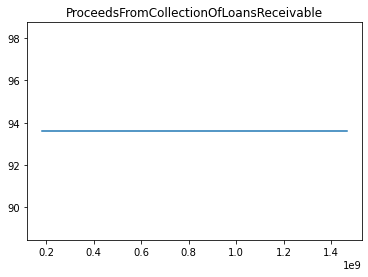

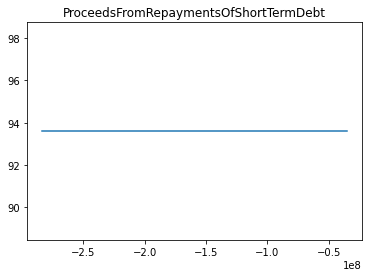

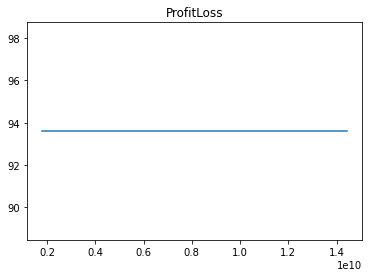

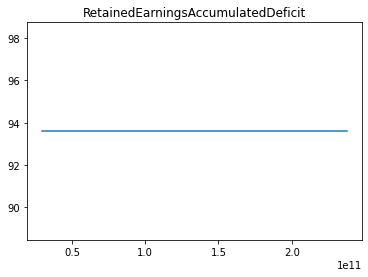

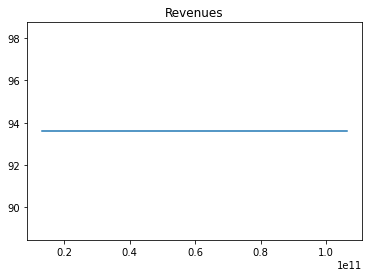

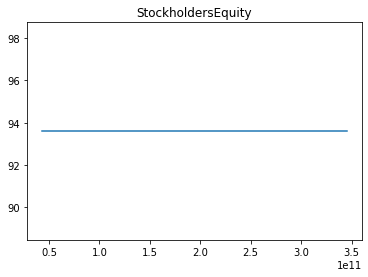

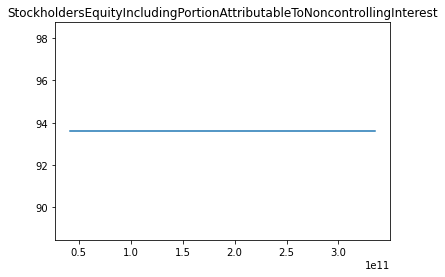

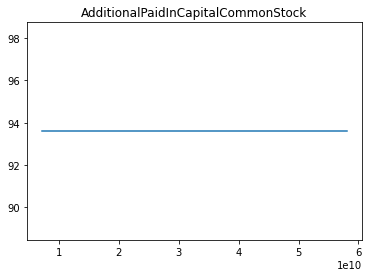

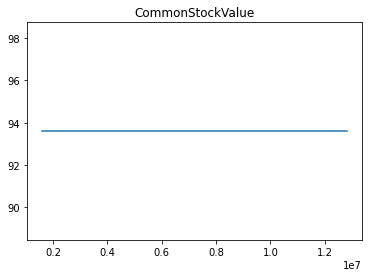

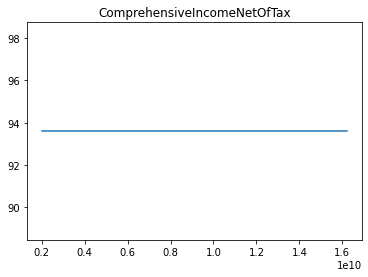

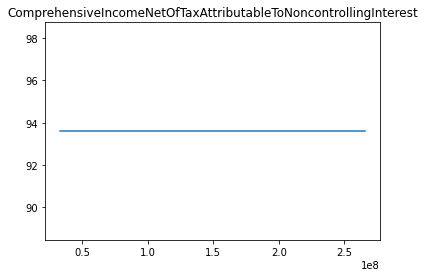

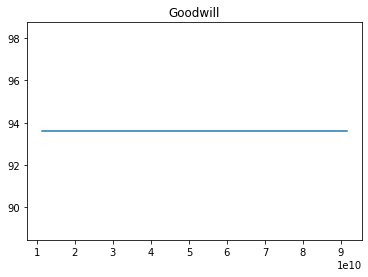

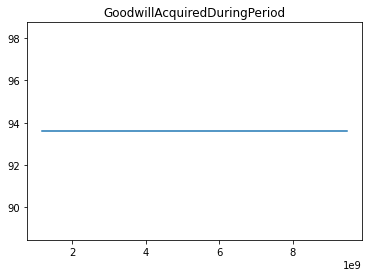

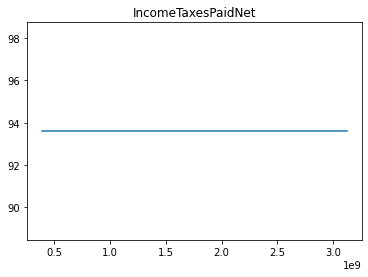

In [57]:
model = rfr["model"]
test = product_refined
for col in product_refined.columns:
    try:
        test_outputs = []
        mid = int(rfd[col].mean())
        delta = int(mid / 5)
        start = mid -  4 * (delta)
        end = mid + 4 * (delta)
        for i in range(start,end,delta):
            test[col] = i
            y = model.predict(test)[0]
            test_outputs.append({col:i,"y":y})
        t = pd.DataFrame(test_outputs)
        plt.plot(t[col],t["y"])
        plt.title(col)
        plt.show()
    except:
        continue

In [55]:
delta_df = rfd.copy()
analysis = []
for col in delta_df.columns:
    delta_df[col] = delta_df[col].pct_change()
    analysis.append({"col":col,"max":delta_df[col].max()})

In [56]:
pd.DataFrame(analysis).sort_values("max")

,col,max
26,CommonStockValue,0.000000
33,year,0.000497
21,RetainedEarningsAccumulatedDeficit,0.090221
23,StockholdersEquity,0.100385
34,adjclose,0.121430
24,StockholdersEquityIncludingPortionAttributable...,0.138370
12,MinorityInterest,0.144167
25,AdditionalPaidInCapitalCommonStock,0.162583
29,Goodwill,0.260108
0,AccumulatedOtherComprehensiveIncomeLossNetOfTax,0.339682
